## Mixing styles using oscillating goal training

In this notebook, we will attempt to take an image and transfer onto it the style of two different artists mixed together. Let's see what happens!

This method is based on
1. [A Neural algorithm for artistic style](https://arxiv.org/abs/1508.06576).
2. My own research involving training materials to have multiple functionalities/properties

In [19]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Add your style path and content path here

Neural style transfer requires three images:
1. A content image
2. A style image
3. A base image 

The base image is trained to have the content of the content image, and the style of the style image. Below, we first define paths to each respective image and load each image using the *image_loader* function which converts the image to a torch.Tensor object.

If you are playing around with this notebook, all that needs to be changed are these image paths and the rest of the notebook with work for you.

In [20]:
StylePath = 'path to style images/'#CHANGE ME
ContentPath = 'path to content images/'#CHANGE ME

style_image_path = StylePath + 'style image name 1'#CHANGE ME
style_image_path_2 = StylePath + 'style image name 2'#CHANGE ME

base_image_path = ContentPath+'content image name'#CHANGE ME

In [10]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 256
loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img = image_loader(style_image_path)
style_img_2 = image_loader(style_image_path_2)
content_img = image_loader(base_image_path)


Let's take a look at the images we we have loaded! We need to define a special version of *imshow* to work with an image of torch.Tensor datatype. 

The style images that I hope to mix are Picasso's *Les Demoiselles d'Avignon* and Van Gogh's *Sunflowers*  which are plotted as Style Image 1 and Style Image 2 respectively. The content image I have chosen to use is a picture of me in front of Fontaines de la Concorde in Paris.

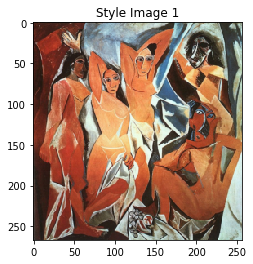

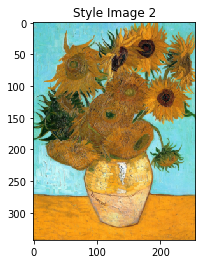

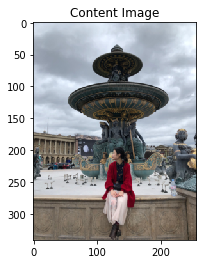

In [11]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

plt.figure()
imshow(style_img, title='Style Image 1')

plt.figure()
imshow(style_img_2, title='Style Image 2')

plt.figure()
imshow(content_img, title='Content Image')


# Neural style transfer 

Below, we define the necessary functions to carry out Neural style transfer. Neural style transfer is used to combine the style and content of two images. Our ultimate goal will be to first mix two styles before combining it with the content of an image, but we will first start with the simpler task. This portion of code is heavy adapted from the following link: [NEURAL TRANSFER USING PYTORCH](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html).

To train an images to have the attributes we want, we must first define functions to measure how well we are doing. This is done using the *ContentLoss* and *StyleLoss* classes, which are used to compare the 'content' of two images and 'style' of two images respectively. Before we can compare 'content' and 'style', we first need to define what we mean by these words.



Our representation of content will simply be the output of selected convolutional layers in a neural network.

In [91]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

 For our representation of style, we will take the feature maps of selected convolutional layers and compute correlations between them. This is handled using the *gram_matrix* function which is called in the *StyleLoss* class. 

In [92]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

We will be using the [VGG19 neural network](http://www.robots.ox.ac.uk/~vgg/research/very_deep/) pretrained on the [ImageNet](http://www.image-net.org/) database to extract the 'content' and 'style' of various images. 

In [15]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Some normalizations of the input images are needed to get the network to function properly.

In [16]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std


## Defining convolutional layers to use

As mentioned above, our representations of content and style are transformations of the feature maps of convolutional layers in VGG19. Here, we specify exactly which convolutional layers to use for each representation.



In [17]:
content_layers_default = ['conv_14']
style_layers_default = ['conv_1', 'conv_3', 'conv_5', 'conv_9', 'conv_13']

The VGG19 network is organized in blocks of convolutional layers separated by a downsampling operation (max-pooling). To figure out which block each layer we use is from, we can run the following code:

In [18]:
i = 0
j = 1
k = 0

for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
        i += 1
        k +=1
        name = 'conv_{}'.format(i)
        print(name,':' ,'block_',j, 'conv_',k)
    elif isinstance(layer, nn.ReLU):
        name = 'relu_{}'.format(i)
        # The in-place version doesn't play very nicely with the ContentLoss
        # and StyleLoss we insert below. So we replace with out-of-place
        # ones here.
        layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
        name = 'pool_{}'.format(i)
        j += 1
        k = 0
    elif isinstance(layer, nn.BatchNorm2d):
        name = 'bn_{}'.format(i)
    else:
        raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))


conv_1 : block_ 1 conv_ 1
conv_2 : block_ 1 conv_ 2
conv_3 : block_ 2 conv_ 1
conv_4 : block_ 2 conv_ 2
conv_5 : block_ 3 conv_ 1
conv_6 : block_ 3 conv_ 2
conv_7 : block_ 3 conv_ 3
conv_8 : block_ 3 conv_ 4
conv_9 : block_ 4 conv_ 1
conv_10 : block_ 4 conv_ 2
conv_11 : block_ 4 conv_ 3
conv_12 : block_ 4 conv_ 4
conv_13 : block_ 5 conv_ 1
conv_14 : block_ 5 conv_ 2
conv_15 : block_ 5 conv_ 3
conv_16 : block_ 5 conv_ 4


# Neural style transfer for one style

We are now ready to do neural style transfer! The function *get_style_model_and_losses* takes in the style image, content image as well as the specific convolutional layers we specified above and returns objects that we will use to compute the respective content and style comparisons per layer.

In [97]:
# desired depth layers to compute style/content losses :

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

We will use L-BFGS to do the optimization, which has been found to work well on this problem.

In [98]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer


The function *run_style_transfer* runs the optimization for neural style transfer. The loss function used is a weighted combination of the style difference between the base image and the style image and the content diffrerence between the base image and content image. 

The content and style representations for each layer specified is computed for each of the images and then compared using an MSE loss function.

In [99]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=50,
                       style_weight=100, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()
                
                # sphinx_gallery_thumbnail_number = 4
            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img


## Adding noise to the input image

The last thing we are going to do before actually training the images is to add a little bit of noise to the image to give the result a bit of uncertainty! This is reflective of an artist's experience of never being able to make the exact same painting twice.

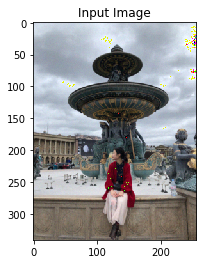

In [100]:
input_img = content_img.clone() + 0.01*torch.randn(content_img.data.size(), device=device)

plt.figure()
imshow(input_img, title='Input Image')

## Transfering style 1 to the input image + noise

Finally we are going to use all of the functions and classes we wrote on an actual image! Here we will take the style of Picasso's *Les Demoiselles d'Avignon* and apply it to the above image.

In [107]:
style_layers_default = ['conv_1', 'conv_3', 'conv_5', 'conv_9', 'conv_13']

output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=200,
                            style_weight=10000, content_weight=1)



Building the style transfer model..


/Users/jiayiwu/anaconda/envs/ML3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/Users/jiayiwu/anaconda/envs/ML3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Optimizing..
run [50]:
Style Loss : 9.625264 Content Loss: 5.273761

run [100]:
Style Loss : 7.572619 Content Loss: 5.046712

run [150]:
Style Loss : 6.576037 Content Loss: 4.908294

run [200]:
Style Loss : 6.003611 Content Loss: 4.745503



The result is plotted below! It looks like it works :D. The colors of the Picasso piece are transferred as well as the jagged contours and edges of the objects. Each patch of colors has a harse gradient between each other in true Picasso style.

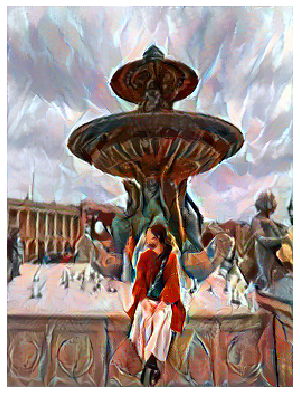

In [109]:
plt.figure(figsize=(6,7))
image = output.cpu().clone()  # we clone the tensor to not do changes on it
image = image.squeeze(0)      # remove the fake batch dimension
image = unloader(image)
plt.imshow(image)
plt.axis('off')
# plt.savefig(datapath + '/picasso.png')

# sphinx_gallery_thumbnail_number = 4


plt.show()
picass_output = output

## Transfering style 2 to the input image + noise

Here we transfer the style of Van Gogh's *Sunflowers* to the input image.

Note that the convolutional layers I am using here (defined a *style_layers_default*) are different than the ones I used when transfering style 1. This is an important feature to have when mixing styles (which will be explained later in the context of compatible and incompatible goals). 

If you just want to transfer one style at a time, then it doesn't matter that the choices of layers are different or the same. You would get different results, but it is not of fundamental importantance to the method. 

In [110]:
input_img = content_img.clone() + 0.01*torch.randn(content_img.data.size(), device=device)
style_layers_default = ['conv_2', 'conv_4', 'conv_6', 'conv_10', 'conv_14']
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img_2, input_img, num_steps=200,
                            style_weight=10000, content_weight=1)


Building the style transfer model..


/Users/jiayiwu/anaconda/envs/ML3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/Users/jiayiwu/anaconda/envs/ML3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Optimizing..
run [50]:
Style Loss : 11.693491 Content Loss: 6.230474

run [100]:
Style Loss : 7.789923 Content Loss: 5.209167

run [150]:
Style Loss : 6.464068 Content Loss: 4.787731

run [200]:
Style Loss : 5.710794 Content Loss: 4.540703



A very different result! You can see that the colors of the image have taken on the colors of the sunflowers. The textures of the objects in the image have taken on the motion of Van Gogh's famous vortex like strokes.

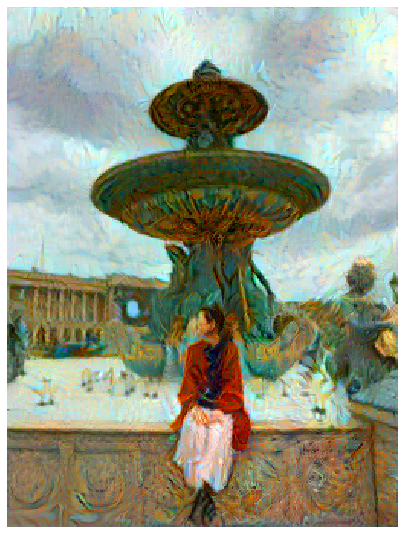

In [111]:
plt.figure(figsize=(7,10))
image = output.cpu().clone()  # we clone the tensor to not do changes on it
image = image.squeeze(0)      # remove the fake batch dimension
image = unloader(image)
plt.imshow(image)
plt.axis('off')
# plt.savefig(datapath + '/vangogh.png')

# sphinx_gallery_thumbnail_number = 4


plt.show()
vangogh_output = output

# Mixing Styles!

To combine the two styles, I use an idea inspired by one of my research projects. In the project, I created an optimization methodology (inspired by nature) that is able to design adaptable materials. This simply means that I create materials that can change forms/behavior/properties/etc. depending on its environment using the following process:

1. Train a material to learn one goal (form/behavior/property/etc.), until you are satisfied :D
2. Train the same material to learn another goal, and halt the training when you are satisfied. 
3. Cycle 1. and 2. until .. well .. you are satisfied :P

We say that two goals are *compatible* if both goals can be achieved at the same time. We say that two goals are *incompatible* if both goals are not achievable at the same time. The above optimization process will likely find a solution satisfying both goals if they are compatible and a solution that is adaptable if the goals are incompatible. By adaptable, we mean that you only need to change the solution slightly to go back and forth between the goals.

Let's transport all of this into the context of this project! My goal is to mix two styles together (two goals!). What I think will work is the following:

Let the learner, which is the optimizer that mimics the style of a painting, repeatedly change its mind about which style it prefers. The learner oscillates between learning how to paint like Van Gogh and learning how to paint like Picasso. After several cycles, the hope is that the learner ends up painting in a style of its own that has qualities of both!

Now a technical note about compatibility and the choice of convolutional layers. I want the resulting image to be a direct mix of the two styles (satisfy both goals) and so I need my goals to be compatible. The styles of Van Gogh and Picasso in the two paintings I chose are obviously different and so if I choose to use the same convolutional layers to compare for both images, the problem is in the incompatible regime. In other words, I simply can't force the style representation of the resulting image to be the same as both Van Gogh and Picasso in the same convolutional layers. An easy fix to this is to target the style representation of different convolutional layers for each image, making the problem a compatible one.

## Let's reset the input image!

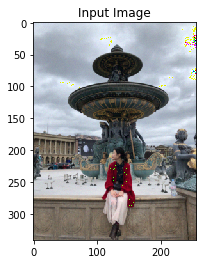

In [112]:
input_img = content_img.clone() + 0.01*torch.randn(content_img.data.size(), device=device)
plt.figure()
imshow(input_img, title='Input Image')

 ## Oscillating styles 60 times 
 
Here I oscillate style goals 60 times! I run each goal for 10 iterations. The learner trains to paint like Van Gogh in one set of convolutional layers and then trains to learn to paint like Picasso in another set of layers.

Building the style transfer model..


/Users/jiayiwu/anaconda/envs/ML3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/Users/jiayiwu/anaconda/envs/ML3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Optimizing..


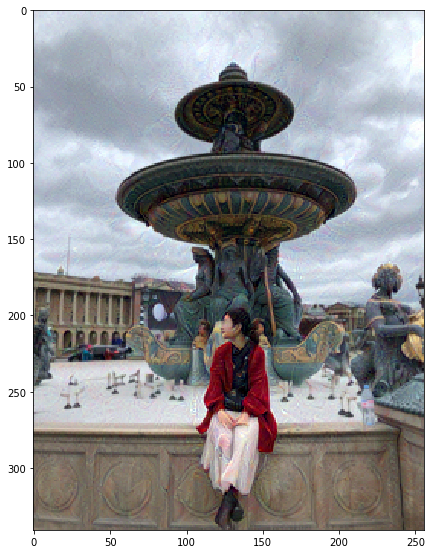

Building the style transfer model..
Optimizing..


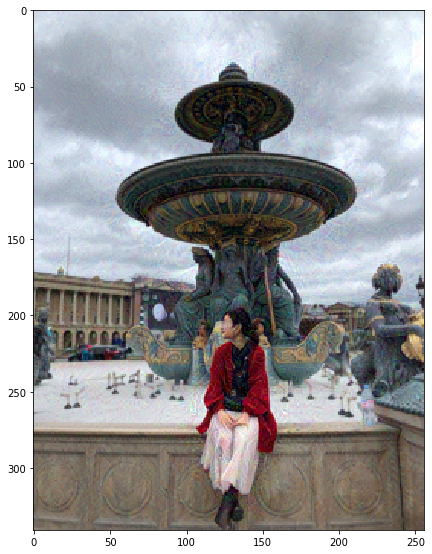

Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..


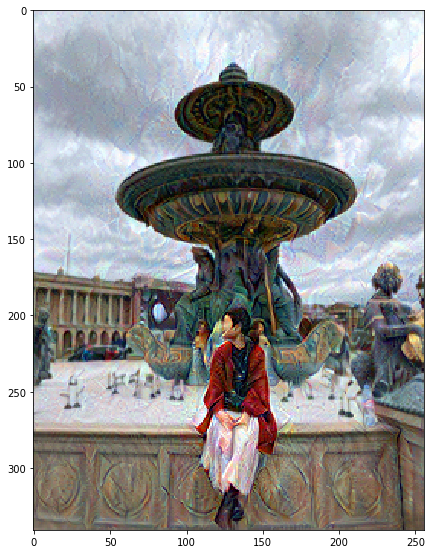

Building the style transfer model..
Optimizing..


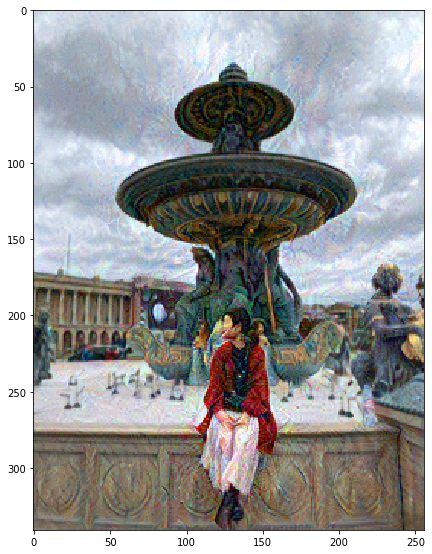

Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..


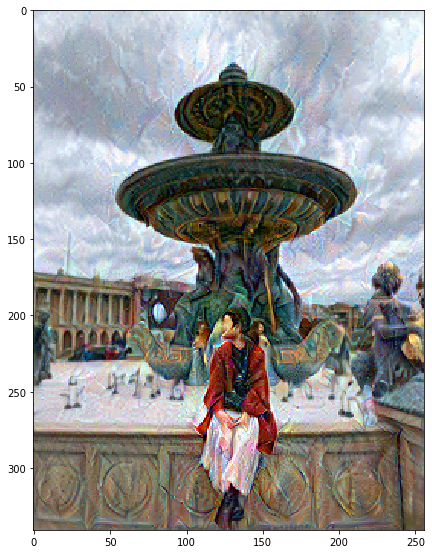

Building the style transfer model..
Optimizing..


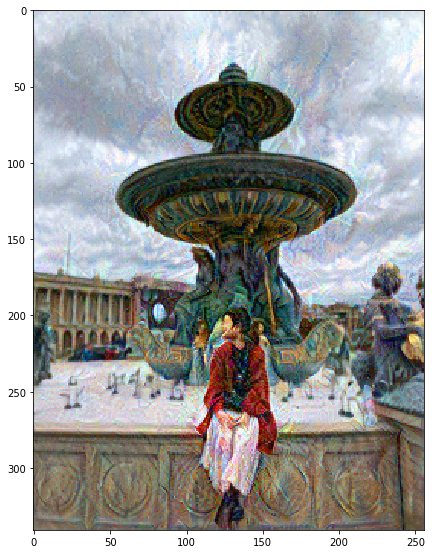

Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..


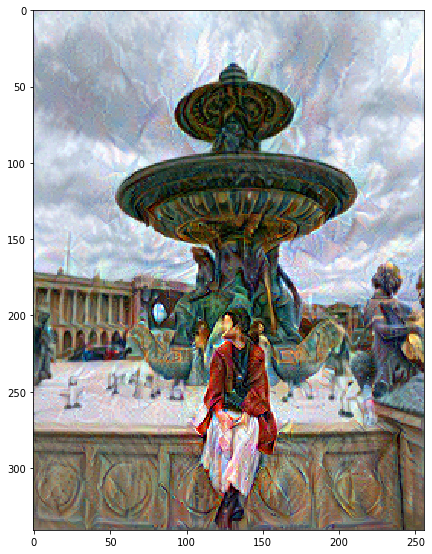

Building the style transfer model..
Optimizing..


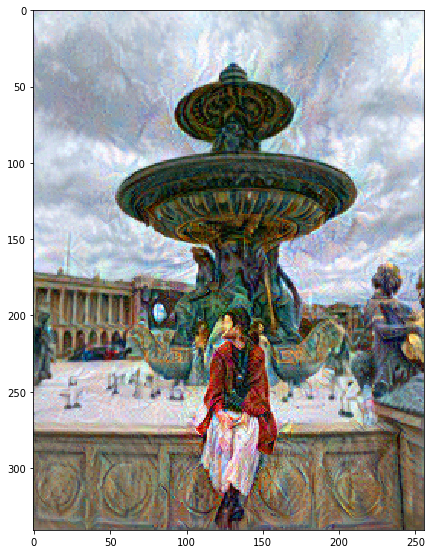

Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..


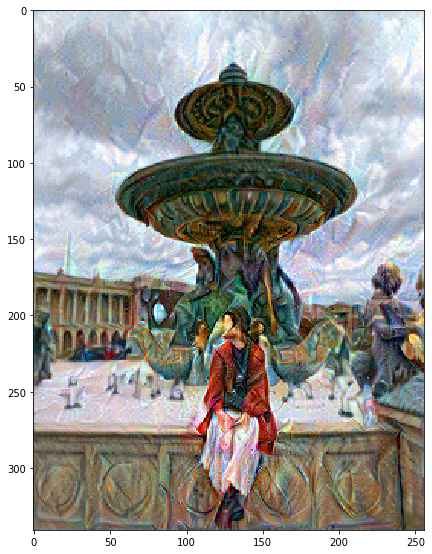

Building the style transfer model..
Optimizing..


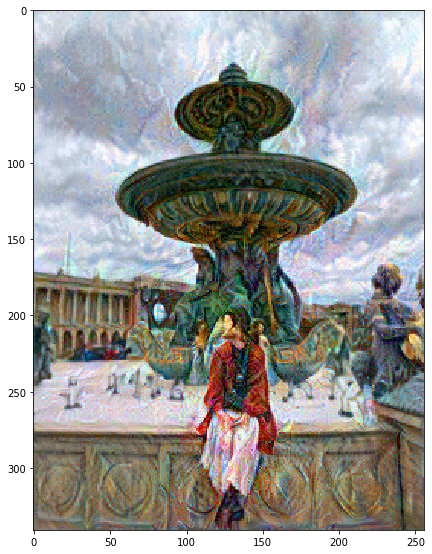

Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..


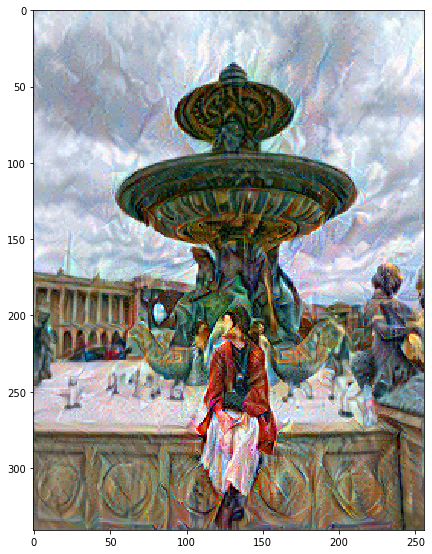

Building the style transfer model..
Optimizing..


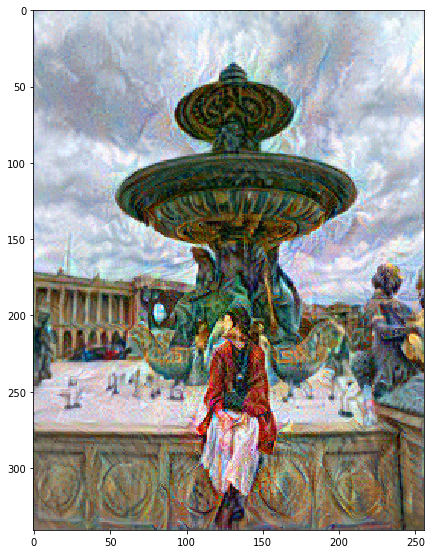

Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..


In [113]:
output = input_img
for i in range(60):
    for j in range(2):
        if j ==0:
            SI = style_img
            style_layers_default = ['conv_1', 'conv_3', 'conv_5', 'conv_9', 'conv_13']
           
        if j ==1:
            SI = style_img_2
            style_layers_default = ['conv_2', 'conv_4', 'conv_6', 'conv_10', 'conv_14']
            
        output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                                content_img, SI, output, num_steps=10)
        if i % 10 == 0:

            plt.figure(figsize=(7,10))
            image = output.cpu().clone()  # we clone the tensor to not do changes on it
            image = image.squeeze(0)      # remove the fake batch dimension
            image = unloader(image)
            plt.imshow(image)

            plt.ioff()
            plt.show()
    

Look at what we get :D !

(-0.5, 255.5, 340.5, -0.5)

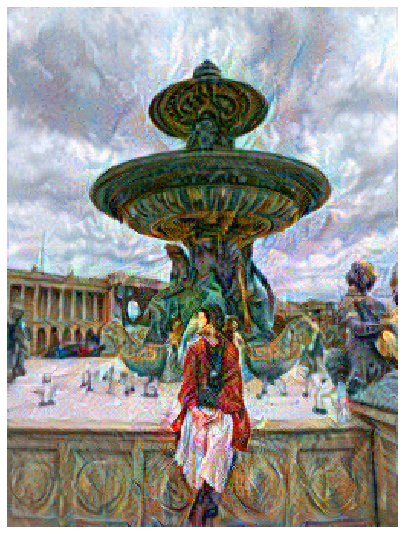

In [114]:
plt.figure(figsize=(7,10))
image = output.cpu().clone()  # we clone the tensor to not do changes on it
image = image.squeeze(0)      # remove the fake batch dimension
image = unloader(image)
plt.imshow(image)
plt.axis('off')


# Some further ideas

Check out the following [blog post](https://www.hallojiayi.com/post/let-machine-help-you-design-your-own-art-style) for a summary of this project.

Theres a lot of additional things one can do. This oscillating goal idea is not limited to two goals. You can use it to mix 3 or more styles! Theres a lot of things you can play with for example the oscillating frequency (the number of iterations to train per goal). The oscillating frequencies also need not to be the same for each style! One can imagine using it to weigh the proportion of style one wants in the mixture. Perhaps you want more Van Gogh and less Picasso, etc. You can train the learner to learn Van Gogh's style for longer than Picasso's style in each cycle.

Note that since it's compitable goal optimization, one can maybe avoid oscillating goals entirely and simply edit the loss function of neural art transfer to include a second style (using different layers). This might also work pretty well :D!

Have fun with it!

Also note the state of art in neural art transfer is using GANS. Here is a popular example:
[Cycle-GAN](https://arxiv.org/pdf/1703.10593.pdf).